In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import string

from matplotlib import pyplot
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [3]:
songs_df = pd.read_json('data/songs.json')
songs_df = songs_df.loc[songs_df.lyrics != '', :] # Empty Lyrics
songs_df = songs_df.loc[~songs_df.lyrics.str.contains(r'\[[^]]+\]')] # Contains Brackets - Indicating Other Artists
songs_df['lyrics'] = songs_df['lyrics'].apply(lambda s: s.translate(str.maketrans('', '', string.punctuation))) # Remove punctuation
songs_df['lyrics'] = songs_df['lyrics'].apply(str.lower) # Lowercase all words
songs_df = songs_df.drop_duplicates(subset=['song']) # Drop duplicate songs
songs_df = songs_df.loc[songs_df['artist'].isin(['Jonas Brothers', '2Pac'])]

songs_df.sample(10)

,artist,lyrics,song
129,Jonas Brothers,come back to me baby ill come back to you you ...,Comeback
848,2Pac,rebel rebel rebel 2pac they just cant stand th...,Rebel Of The Underground
107,Jonas Brothers,you say yes yes i say no no you say stop and i...,Hello Goodbye
556,Jonas Brothers,im hot youre cold you go around like you know ...,Burnin' Up
750,2Pac,yeah hehehahaha we goin platinum nigga plaahah...,5 Deadly Venomz
807,2Pac,outlawz in this no doubt death row makaveli re...,Just Like Daddy
851,2Pac,you could get the finga the middle come and ge...,Point The Finga
766,2Pac,get on yo knees nigga get on yo knees and pray...,Hell 4 A Hustler
918,2Pac,i aint got no motherfuckin friends thats why i...,Hit Em Up
141,Jonas Brothers,spending all your time with your new friends a...,Used To Be


In [4]:
print(songs_df.shape)
print(songs_df.groupby('artist')['song'].count())

(304, 3)
artist
2Pac              190
Jonas Brothers    114
Name: song, dtype: int64


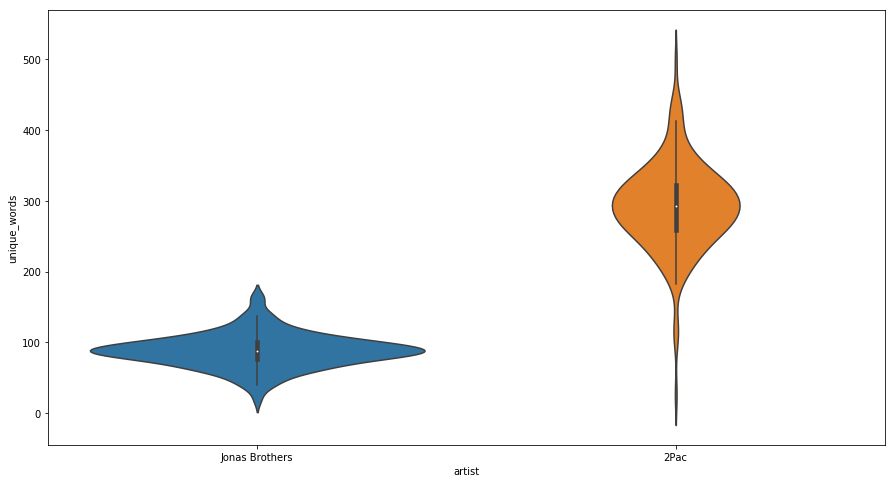

In [5]:
songs_df['unique_words'] = songs_df['lyrics'].apply(lambda l: len(set(l.split())))
songs_df = songs_df.query('unique_words > 10')

fig, ax = pyplot.subplots(figsize=(15, 8))
sns.violinplot(x=songs_df['artist'], y=songs_df['unique_words'], ax=ax)

In [6]:
def model(unique_words):
    if unique_words > 170:
        return '2Pac'
    else:
        return 'Jonas Brothers'

In [7]:
predictions = songs_df.unique_words.apply(model)

print('Accurary:', (songs_df.artist == predictions).sum() / len(songs_df))

Accurary: 0.9868421052631579


In [8]:
songs_df.query('artist == "2Pac" & unique_words < 170')

,artist,lyrics,song,unique_words
739,2Pac,sun comes up on another morning my mind never ...,Catching Feelins,129
831,2Pac,2pac 2pac go ahead static is the last thing ya...,Static I (Remix 1),114
838,2Pac,laughter echoed ive changed you mothafuckas ki...,Something 2 Die 4,105
853,2Pac,another shady mission tricks like watching pic...,Playa Cardz Right,26


In [9]:
def show_wordcloud(songs_df, artist):
    artist_lyrics = ' '.join(songs_df.query(f'artist == "{artist}"').lyrics)
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(artist_lyrics)
    pyplot.figure(figsize=(15, 8))
    pyplot.imshow(wordcloud, interpolation="bilinear")
    pyplot.axis("off")
    pyplot.show()

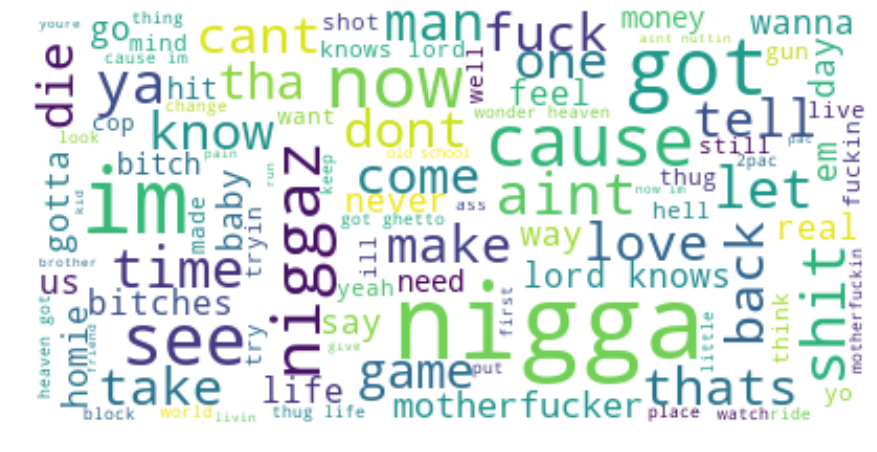

In [10]:
show_wordcloud(songs_df, artist='2Pac')

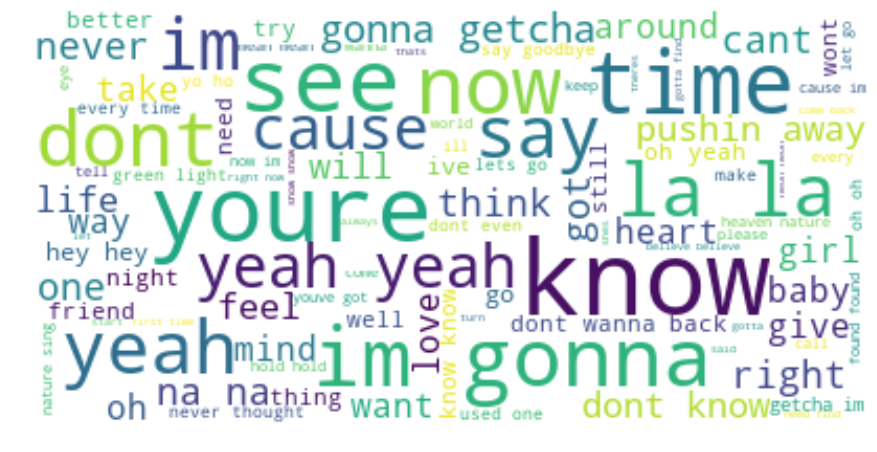

In [11]:
show_wordcloud(songs_df, artist='Jonas Brothers')

In [12]:
vectorizer = CountVectorizer()
song_vectors = vectorizer.fit_transform(songs_df['lyrics'])
song_vector_df = pd.DataFrame(song_vectors.toarray(), columns=vectorizer.get_feature_names(), index=songs_df['artist'])


tsne = TSNE()
tsne_song_vectors = tsne.fit_transform(song_vector_df)
tsne_song_vectors_df = pd.DataFrame(tsne_song_vectors, columns=['x', 'y'])
tsne_song_vectors_df['artist'] = song_vector_df.index

pca = PCA(n_components=2)
pca_song_vectors = pca.fit_transform(song_vector_df)
pca_song_vectors_df = pd.DataFrame(pca_song_vectors, columns=['x', 'y'])
pca_song_vectors_df['artist'] = song_vector_df.index

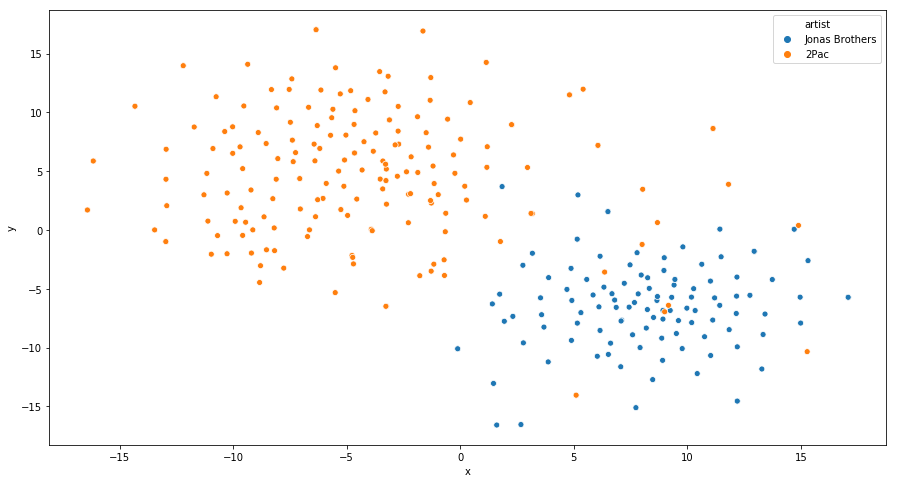

In [13]:
fig, ax = pyplot.subplots(figsize=(15, 8))
sns.scatterplot(x='x', y='y', hue='artist', data=tsne_song_vectors_df, ax=ax)

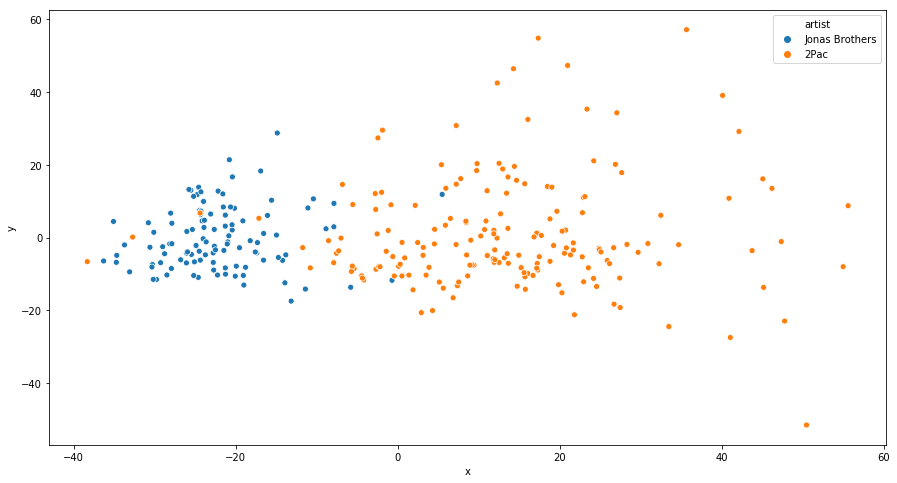

In [14]:
fig, ax = pyplot.subplots(figsize=(15, 8))
sns.scatterplot(x='x', y='y', hue='artist', data=pca_song_vectors_df, ax=ax)

In [15]:
train_df, test_df = train_test_split(song_vector_df, stratify=song_vector_df.index)
mnb = MultinomialNB()
mnb.fit(train_df, train_df.index)
predictions = mnb.predict(test_df)
mnb.score(test_df, test_df.index)

0.9736842105263158